In [137]:
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
import torch
import random
import torch.nn.functional as F

In [138]:
with open("expression_db.json") as f:
    db = json.load(f)

reverse_database = {(value[0], value[1]) : key for key, value in db.items()}

In [139]:
all_premises = []
premise_labels = []
premise_idx = []
# take most frequent libraries for analysis
for i, (key, value) in enumerate(db.items()):
    if value[0] == "pred_set" or value[0] == "relation" or value[0] == "list":# or value[0] == "rich_list" or value[0] == "prim_rec": #or value[0] == "pred_set" or value[0] == "set":
        all_premises.append(key)
        premise_labels.append(value[0])
        premise_idx.append(i)

In [140]:

with open('vanilla_embs.pk', 'rb') as f:
    original_embeddings = pickle.load(f)

with open('gnn_embs.pk', 'rb') as f:
    gnn_embeddings = pickle.load(f)


In [141]:
from sklearn.manifold import TSNE
import plotly.express as px
def plot_reps(reps, labels, n_components, graph_name):
    tsne = TSNE(n_components)
    tsne_result = tsne.fit_transform(reps.detach().cpu().numpy())

    color_dict = {}

    i = 0

    labels_ = list(set(labels))
    for label in labels_:
        color_dict[label] = i
        i += 1

    color_dict["POI1"] = i + 1
    color_dict["POI2"] = i + 1
    color_dict["POI3"] = i + 1
    color_dict["POI4"] = i + 1

    if n_components == 3:

        df_list = []
        for i, premise in enumerate(all_premises):
            # set custom markers for points of interest
            if i == 1255 or i == 1256 or i == 1290 or i == 1291:
                labels[i] = "POI1"
            if i == 403 or i == 418:
                labels[i] = "POI2"
            if i == 497 or i == 387:
                labels[i] = "POI3"
            if i == 1097 or i == 810 or i == 591:
                labels[i] = "POI4"
            df_list.append({'Premise': db[premise][-1], 'X': tsne_result[i,0], "Y": tsne_result[i,1], "Z": tsne_result[i,2], "Thm": premise_labels[i], "Idx": i})

        df = pd.DataFrame.from_records(df_list)


        fig = px.scatter_3d(df, x = 'X', y = 'Y', z = 'Z', color = 'Thm', hover_name = "Premise", hover_data = ["Thm", "Idx"])
        fig.update_traces(marker_size = 3)

        fig.write_html(graph_name+".html", auto_open=True)
    elif n_components == 2:
        ax = plt.figure(figsize=(16,10)).gca()
        scatter = ax.scatter(x = tsne_result[:,0], y = tsne_result[:,1], c = [color_dict[l] for l in labels])#, label = labels_th)

        legend1 = ax.legend(*(scatter.legend_elements()[0], labels_),
                        loc="lower left", title="Classes", fontsize=16)
        ax.add_artist(legend1)
        plt.savefig(graph_name, format='pdf')

        plt.show()
    else:
        raise NotImplementedError

    return tsne_result, premise_labels



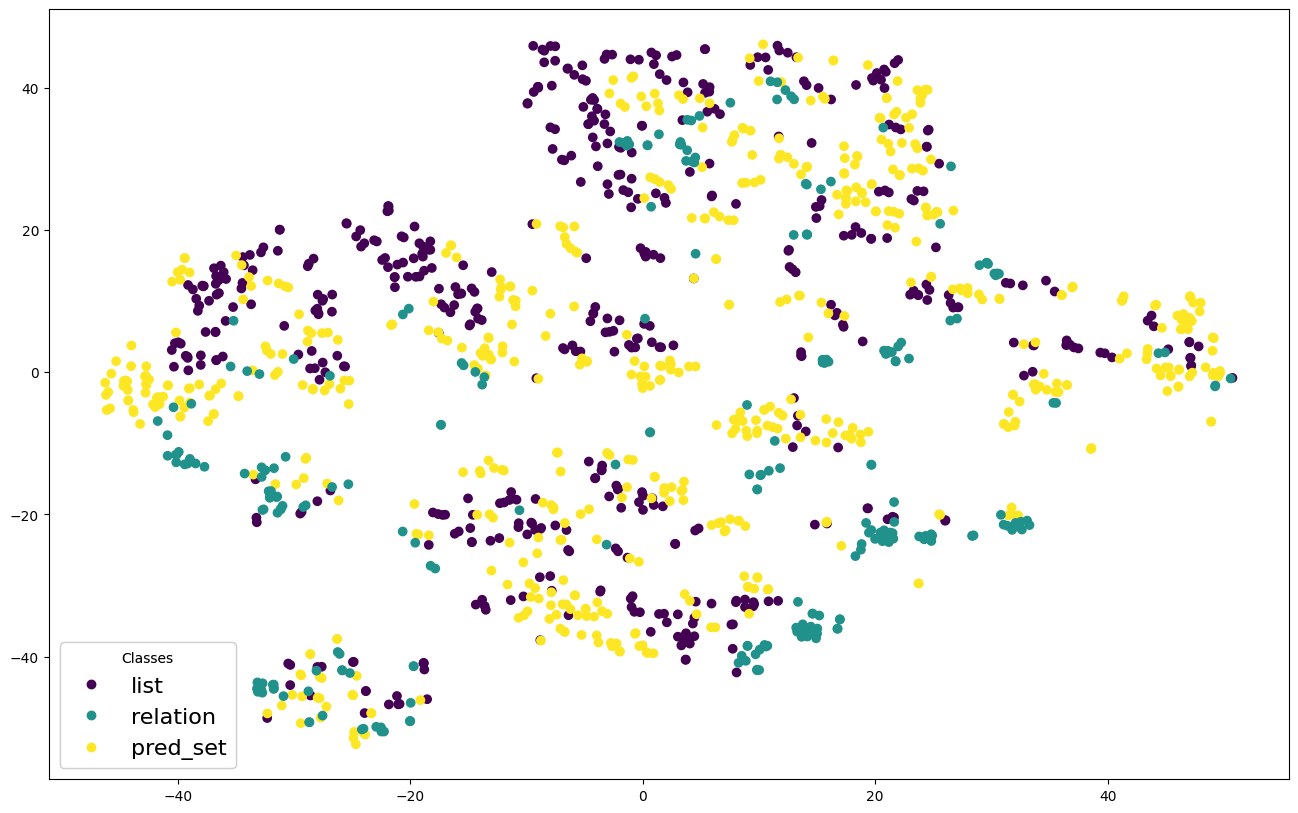

In [142]:
vanilla_tsne, v_labs = plot_reps(original_embeddings, premise_labels, 2, "original_premise_embeddings.pdf")

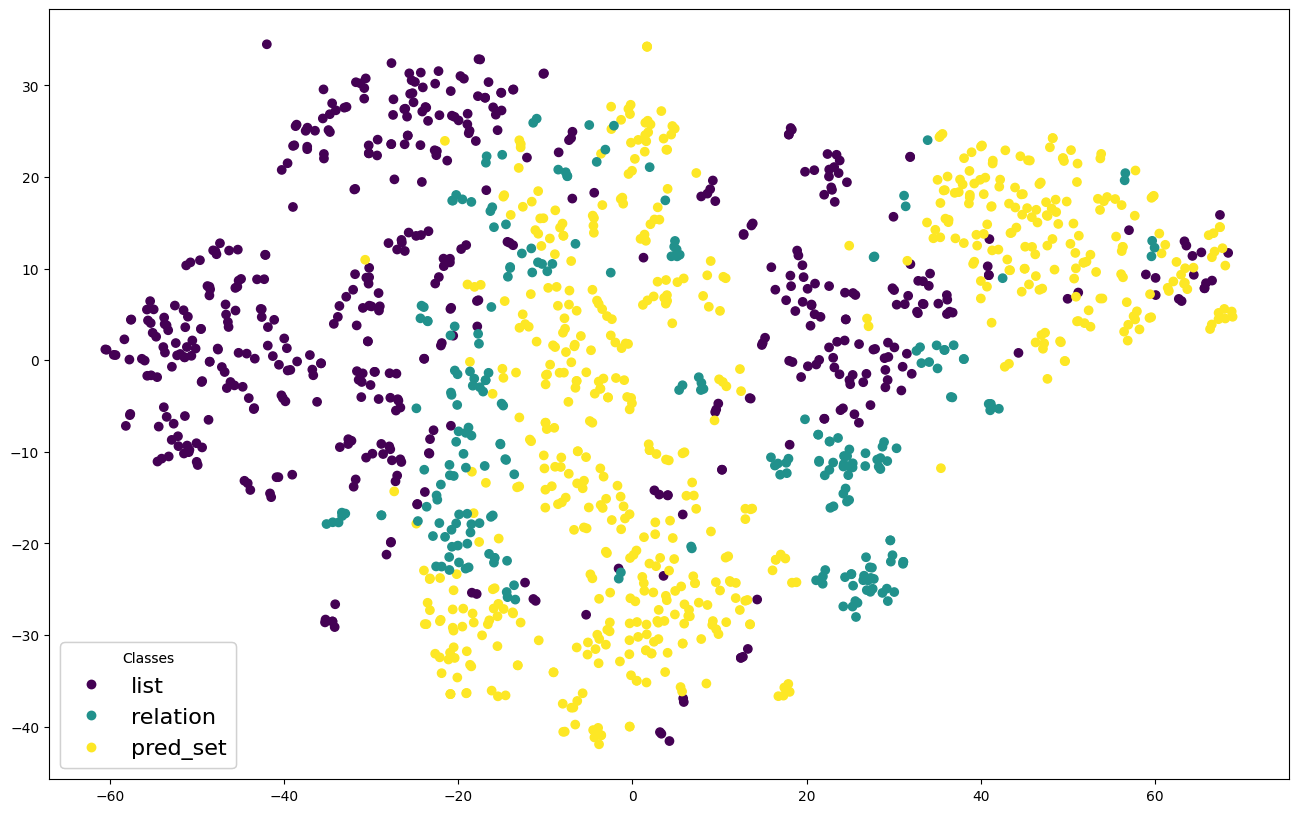

In [143]:
gnn_tsne, g_labs = plot_reps(gnn_embeddings, premise_labels, 2, "gnn_premise_embeddings.pdf")

In [144]:
vanilla_tsne, v_labs = plot_reps(original_embeddings, premise_labels, 3, "original_premise_embeddings")

In [145]:
gnn_tsne, g_labs = plot_reps(gnn_embeddings, premise_labels, 3, "gnn_premise_embeddings")

In [146]:
cos = lambda m: F.normalize(m) @ F.normalize(m).t()

In [147]:
original_cosine_closest = {}
gnn_cosine_closest = {}
def get_closest(ind):
    inds = torch.topk(cos(original_embeddings)[ind], 5)[1][1:]
    original_cosine_closest[db[all_premises[ind]][-1]] = [db[all_premises[x]][-1] for x in inds]
    inds = torch.topk(cos(gnn_embeddings)[ind], 5)[1][1:]
    gnn_cosine_closest[db[all_premises[ind]][-1]] = [db[all_premises[x]][-1] for x in inds]


In [148]:
for i in range(len(all_premises)):
    get_closest(i)
    

In [149]:
gnn_cosine_closest

{'FINITE 𝕌(:α # β) ⇔ FINITE 𝕌(:α) ∧ FINITE 𝕌(:β)': ['INFINITE 𝕌(:α) ⇔ ∀(s :α -> bool). FINITE s ⇒ s ⊂ 𝕌(:α)',
  'INFINITE 𝕌(:α) ⇔ ∃(f :α -> α). (∀(x :α) (y :α). f x = f y ⇒ x = y) ∧ ∃(y :α). ∀(x :α). f x ≠ y',
  '∀(P :α -> bool) (Q :β -> bool). FINITE P ∧ FINITE Q ⇒ FINITE ((P × Q) :α # β -> bool)',
  'FINITE (POW (s :α -> bool)) ⇔ FINITE s'],
 'LIST_REL (R :α -> β -> bool) (l1 :α list) (l2 :β list) ∧ LIST_REL R (l3 :α list) (l4 :β list) ⇒ LIST_REL R (l1 ++ l3) (l2 ++ l4)': ['LENGTH (x1 :α list) = LENGTH (x2 :β list) ⇒ (LIST_REL (R :α -> β -> bool) (x1 ++ (y1 :α list)) (x2 ++ (y2 :β list)) ⇔ LIST_REL R x1 x2 ∧ LIST_REL R y1 y2)',
  'LIST_REL (R :α -> β -> bool) (l1 :α list) (l2 :β list) ∧ LIST_REL R (l3 :α list) (l4 :β list) ⇔ LIST_REL R (l1 ++ l3) (l2 ++ l4) ∧ LENGTH l1 = LENGTH l2 ∧ LENGTH l3 = LENGTH l4',
  '∀(xs :α list) (ys :β list) (xs1 :α list) (ys1 :β list). LIST_REL (P :α -> β -> bool) (xs ++ xs1) (ys ++ ys1) ∧ LENGTH xs = LENGTH ys ⇒ LIST_REL P xs ys ∧ LIST_REL P xs1 ys1',
  

In [150]:
original_cosine_closest

{'FINITE 𝕌(:α # β) ⇔ FINITE 𝕌(:α) ∧ FINITE 𝕌(:β)': ['COUNTABLE 𝕌(:α # β) ⇔ COUNTABLE 𝕌(:α) ∧ COUNTABLE 𝕌(:β)',
  '(s1 :α -> bool) ⊆ (s2 :α -> bool) ⇒ REL_RESTRICT (R :α -> α -> bool) s1 ⊆ᵣ REL_RESTRICT R s2',
  'INFINITE 𝕌(:α) ⇔ ∀(s :α -> bool). FINITE s ⇒ s ⊂ 𝕌(:α)',
  '(R :α -> α -> bool) equiv_on (s :α -> bool) ⇒ (∅ :α -> bool) ∉ partition R s'],
 'LIST_REL (R :α -> β -> bool) (l1 :α list) (l2 :β list) ∧ LIST_REL R (l3 :α list) (l4 :β list) ⇒ LIST_REL R (l1 ++ l3) (l2 ++ l4)': ['(∀(m :num). m < (n :num) ⇒ (f1 :num -> α) m = (f2 :num -> α) m) ⇒ GENLIST f1 n = GENLIST f2 n',
  '(∀(x :α). (P :α -> bool) x ⇒ (Q :α -> bool) x) ⇒ EXISTS P (l :α list) ⇒ EXISTS Q l',
  '(∀(x :α). (P :α -> bool) x ⇒ (Q :α -> bool) x) ⇒ EVERY P (l :α list) ⇒ EVERY Q l',
  '(R1 :α -> β -> bool) ⊆ᵣ (R2 :α -> β -> bool) ∧ (S1 :γ -> α -> bool) ⊆ᵣ (S2 :γ -> α -> bool) ⇒ R1 ∘ᵣ S1 ⊆ᵣ R2 ∘ᵣ S2'],
 'LIST_REL (R :α -> β -> bool) (l1 :α list) (l2 :β list) ∧ LIST_REL R (l3 :α list) (l4 :β list) ⇔ LIST_REL R (l1 ++ l3) (l

In [151]:

examples = []
inds = [i for i,x in enumerate(all_premises)]
random.shuffle(inds)

num_premises = 20

# only print expressions under 100 characters for readability
short_only = True

j = 0
for i in inds:
    if j == num_premises:
        break
    prem = db[all_premises[i]][-1]

    #
    if short_only:
        if len(gnn_cosine_closest[prem][0]) < 100 and len(original_cosine_closest[prem][0]) < 100 and len(prem) < 100:
            examples.append((prem, gnn_cosine_closest[prem][0], original_cosine_closest[prem][0]))
            print(f"Expression: {prem}\n GNN: {gnn_cosine_closest[prem][0]}\n Original: {original_cosine_closest[prem][0]}\n")
            j += 1
    else:
        examples.append((prem, gnn_cosine_closest[prem][0], original_cosine_closest[prem][0]))
        print(f"Expression: {prem}\n GNN: {gnn_cosine_closest[prem][0]}\n Original: {original_cosine_closest[prem][0]}\n")
        j += 1



Expression: set (SNOC (x :α) (ls :α list)) = x INSERT set ls
 GNN: set (FILTER (P :α -> bool) (l :α list)) = {x | P x} ∩ set l
 Original: set ([] :α list) = (∅ :α -> bool) ∧ set ((h :β)::(t :β list)) = h INSERT set t

Expression: ∀(s :α -> bool) (t :α -> bool). s ⊆ t ⇒ ∀(f :α -> β). IMAGE f s ⊆ IMAGE f t
 GNN: ∀(f :α -> β) (s :α -> bool) (u :α -> bool) (t :β -> bool). s ⊆ u ∧ IMAGE f u ⊆ t ⇒ IMAGE f s ⊆ t
 Original: ∀(f :α -> β) (s :α -> bool) (t :α -> bool). IMAGE f (s ∪ t) = IMAGE f s ∪ IMAGE f t

Expression: ∀(s :α -> bool) (M :α -> num). (∃(x :α). x ∈ s) ⇔ ∃(x :α). x ∈ s ∧ ∀(y :α). y ∈ s ⇒ M x ≤ M y
 GNN: ∀(s :num -> bool). (∃(n :num). n ∈ s) ⇔ ∃(n :num). n ∈ s ∧ ∀(m :num). m ∈ s ⇒ n ≤ m
 Original: ∀(m :α -> num) (s :α -> bool) (x :α). is_measure_maximal m s x ⇔ x ∈ s ∧ ∀(y :α). y ∈ s ⇒ m y ≤ m x

Expression: ∀(n :num) (l :α list). n < LENGTH l ⇒ ∀(x :α). EL n (SNOC x l) = EL n l
 GNN: ∀(l :α list) (x :α). EL (LENGTH l) (SNOC x l) = x
 Original: ∀(n :num) (l :α list). n < LENGTH l 

In [ ]:
## Convert unicode expressions to latex
# from pylatexenc.latexencode import UnicodeToLatexEncoder
#
# u = UnicodeToLatexEncoder(unknown_char_policy='replace')
# print(u.unicode_to_latex('(R1 :α -> β -> bool) ∩ᵣ (R2 :α -> β -> bool) = R2 ∩ᵣ R1')))
#
# latex_examples = [u.unicode_to_latex(r) for r in examples]